In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import gym
import matplotlib.pyplot as plt
import random
import argparse
from collections import OrderedDict
from copy import copy
# import Learn_Knonlinear as lka
import scipy
import scipy.linalg
from scipy.integrate import odeint
import sys
import os
sys.path.append("../utility")
sys.path.append("../train")
from Utility import data_collecter
os.environ['KMP_DUPLICATE_LIB_OK'] = "TRUE"

In [2]:
Methods = ["KoopmanDerivative","KoopmanRBF",\
            "KNonlinear","KNonlinearRNN","KoopmanU",\
            "KoopmanNonlinearA","KoopmanNonlinear",\
                ]
Method_names = ["KoopmanDerivative","KoopmanRBF",\
            "KDNN","KRNN","DKUC(ours)",\
            "DKAC(ours)","DKN(ours)",\
                ]

In [3]:
def eval_err(suffix,env_name,method_index,samples):
    # method_index = 0
    method = Methods[method_index]
    root_path = "../Data/"+suffix
    print(method)
    if method.endswith("KNonlinear"):
        import Learn_Knonlinear as lka
    elif method.endswith("KNonlinearRNN"):
        import Learn_Knonlinear_RNN as lka
    elif method.endswith("KoopmanNonlinear"):
        import Learn_KoopmanNonlinear_with_KlinearEig as lka
    elif method.endswith("KoopmanNonlinearA"):
        import Learn_KoopmanNonlinearA_with_KlinearEig as lka
    elif method.endswith("KoopmanU"):
        import Learn_Koopman_with_KlinearEig as lka
    for file in os.listdir(root_path):
        if file.startswith(method+"_") and file.endswith("samples{}.pth".format(samples)):
            model_path = file  
    Data_collect = data_collecter(env_name)
    udim = Data_collect.udim
    Nstates = Data_collect.Nstates
    layer_depth = 3
    layer_width = 128
    dicts = torch.load(root_path+"/"+model_path,map_location=torch.device('cpu'))
    state_dict = dicts["model"]
    if method.endswith("KNonlinear"):
        Elayer = dicts["Elayer"]
        net = lka.Network(layers=Elayer,u_dim=udim)
    elif method.endswith("KNonlinearRNN"):
        net = lka.Network(input_size=udim+Nstates,output_size=Nstates,hidden_dim=layer_width, n_layers=layer_depth-1)
    elif method.endswith("KoopmanNonlinear") or method.endswith("KoopmanNonlinearA"):
        layer = dicts["layer"]
        blayer = dicts["blayer"]
        NKoopman = layer[-1]+Nstates
        net = lka.Network(layer,blayer,NKoopman,udim)
    elif method.endswith("KoopmanU"):
        layer = dicts["layer"]
        NKoopman = layer[-1]+Nstates
        net = lka.Network(layer,NKoopman,udim)  
    net.load_state_dict(state_dict)
    device = torch.device("cpu")
    # net.cuda()
    net.double()
    Samples = 5000
    steps = 30
    random.seed(2022)
    np.random.seed(2022)
    times = 4 
    max_loss_all = np.zeros((times,steps))
    mean_loss_all = np.zeros((times,steps))
    with torch.no_grad():
        for i in range(times):
            test_data_path = "../Data/{}{}.npy".format(env_name,i)
            if os.path.exists(test_data_path):
                test_data = np.load("../Data/{}{}.npy".format(env_name,i))
            else:
                test_data = Data_collect.collect_koopman_data(Samples,steps)
                np.save("../Data/{}{}.npy".format(env_name,i),test_data)
            max_loss,mean_loss = lka.K_loss(test_data,net,udim,Nstate=Nstates)
            max_loss_all[i] = max_loss.reshape(-1)
            mean_loss_all[i] = mean_loss.reshape(-1)
    max_mean = np.mean(max_loss_all,axis=0)
    max_std = np.std(max_loss_all,axis=0)
    mean_mean =  np.mean(mean_loss_all,axis=0)
    mean_std =  np.std(mean_loss_all,axis=0)
    np.save("../Prediction_Results/Samples/"+env_name+"_"+method+"samples{}.npy".format(samples),np.array([max_mean,max_std,mean_mean,mean_std]))
    return max_mean,max_std,mean_mean,mean_std

In [4]:
# Methods = ["KoopmanDerivative","KoopmanRBF",\
#             "KNonlinear","KNonlinearRNN","KoopmanU",\
#             "KoopmanNonlinearA","KoopmanNonlinear",\
#                 ]
suffix = "4_23"
env_name = "DampingPendulum"
# for i in range(5):
for i in [2,3,4,5,6]:
    eval_err(suffix,env_name,method_index=4,samples=200)

KoopmanU
KoopmanU
KoopmanU


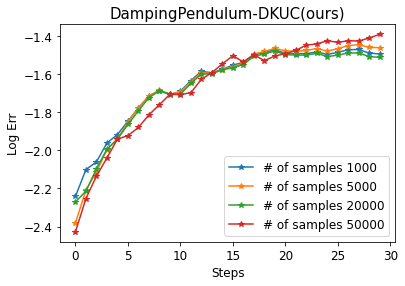

In [5]:
font = {'size'   : 12}
plt.rc('font', **font)
env_name = "DampingPendulum"
index = 4
method_name = Methods[index]
Data = {}
for file in os.listdir('../Prediction_Results'):
    for sample in [1000,5000,20000,50000]:
        if file.startswith(env_name+"_{}samples{}.npy".format(method_name,sample)):
            Data[sample] = np.load("../Prediction_Results/"+file)
            break
for sample in [1000,5000,20000,50000]:
    plt.plot(np.log10(Data[sample][0]),'*-',label="# of samples {}".format(sample),linewidth=1.5)
plt.legend()
plt.xlabel("Steps",fontsize=12)
plt.ylabel("Log Err",fontsize=12)
plt.title(env_name+"-{}".format(Method_names[index]),fontsize=15)
# plt.show()
plt.savefig("../Prediction_Results/"+"Samples"+env_name+"_{}.png".format(method_name),dpi=300)

In [ ]:
#Franka
def eval_err(suffix,env_name,method_index):
    # method_index = 0
    method = Methods[method_index]
    root_path = "../Data/"+suffix
    print(method)
    if method.endswith("KNonlinear"):
        import Learn_Knonlinear as lka
    elif method.endswith("KNonlinearRNN"):
        import Learn_Knonlinear_RNN as lka
    elif method.endswith("KoopmanNonlinear"):
        import Learn_KoopmanNonlinear_with_KlinearEig as lka
    elif method.endswith("KoopmanNonlinearA"):
        import Learn_KoopmanNonlinearA_with_KlinearEig as lka
    elif method.endswith("KoopmanU"):
        import Learn_Koopman_with_KlinearEig as lka
    for file in os.listdir(root_path):
        if file.startswith(method+"_") and file.endswith(".pth"):
            model_path = file  
    Data_collect = data_collecter(env_name)
    udim = Data_collect.udim
    Nstates = Data_collect.Nstates
    layer_depth = 3
    layer_width = 128
    dicts = torch.load(root_path+"/"+model_path)
    state_dict = dicts["model"]
    if method.endswith("KNonlinear"):
        Elayer = dicts["Elayer"]
        net = lka.Network(layers=Elayer,u_dim=udim)
    elif method.endswith("KNonlinearRNN"):
        net = lka.Network(input_size=udim+Nstates,output_size=Nstates,hidden_dim=layer_width, n_layers=layer_depth-1)
    elif method.endswith("KoopmanNonlinear") or method.endswith("KoopmanNonlinearA"):
        layer = dicts["layer"]
        blayer = dicts["blayer"]
        NKoopman = layer[-1]+Nstates
        net = lka.Network(layer,blayer,NKoopman,udim)
    elif method.endswith("KoopmanU"):
        layer = dicts["layer"]
        NKoopman = layer[-1]+Nstates
        net = lka.Network(layer,NKoopman,udim)  
    net.load_state_dict(state_dict)
    device = torch.device("cpu")
    net.cuda()
    net.double()
    Samples = 5000
    steps = 30
    random.seed(2022)
    np.random.seed(2022)
    times = 4 
    max_loss_all = np.zeros((times,steps))
    mean_loss_all = np.zeros((times,steps))
    with torch.no_grad():
        for i in range(times):
            test_data = np.load("../Data/Franka{}.npy".format(i))
            max_loss,mean_loss = lka.K_loss(test_data,net,udim,Nstate=Nstates)
            max_loss_all[i] = max_loss.reshape(-1)
            mean_loss_all[i] = mean_loss.reshape(-1)
    max_mean = np.mean(max_loss_all,axis=0)
    max_std = np.std(max_loss_all,axis=0)
    mean_mean =  np.mean(mean_loss_all,axis=0)
    mean_std =  np.std(mean_loss_all,axis=0)
    np.save("Prediction_Results/"+env_name+"_"+method+".npy",np.array([max_mean,max_std,mean_mean,mean_std]))
    return max_mean,max_std,mean_mean,mean_std

In [ ]:
env_name = "Franka"
Data_collect = data_collecter(env_name)
Samples = 5000
steps = 30
random.seed(2022)
np.random.seed(2022)
times = 4 
max_loss_all = np.zeros((times,steps))
mean_loss_all = np.zeros((times,steps))
with torch.no_grad():
    for i in range(times):
        test_data = Data_collect.collect_koopman_data(Samples,steps)
        np.save("../Data/Franka{}.npy".format(i),test_data)

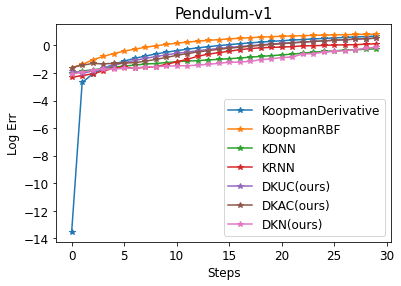

In [7]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
font = {'size'   : 12}

plt.rc('font', **font)
# markers = ['*','+','*','+','*','+','*']
# env_name = "DampingPendulum"
# env_name = "CartPole-v1"
# env_name = "MountainCarContinuous-v0"
env_name = "Pendulum-v1"
# env_name = "Franka"
# env_name = "DoublePendulum"
title = env_name
compare = "max"
# compare = "mean"
for i in range(7):
    index = i
    method = Methods[index]
    file_path = "Prediction_Results/"+env_name+"_"+method+".npy"
    data = np.load(file_path)
    # print(data.shape)
    if compare.startswith("max"):
        plt.plot(np.log10(data[0]),'*-',color = colors[index],label=Method_names[i],linewidth=1.5)
    else:
        plt.plot(np.log10(data[2]),'*-',color = colors[index],label=method)
plt.legend()
# plt.grid(linestyle='-.')
plt.xlabel("Steps",fontsize=12)
plt.ylabel("Log Err",fontsize=12)
plt.title(title,fontsize=15)
plt.savefig("Prediction_Results/"+env_name+"_"+compare+"_new1.png",dpi=300)